<a href="https://colab.research.google.com/github/ryjason/CalculatorApp/blob/master/final_xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

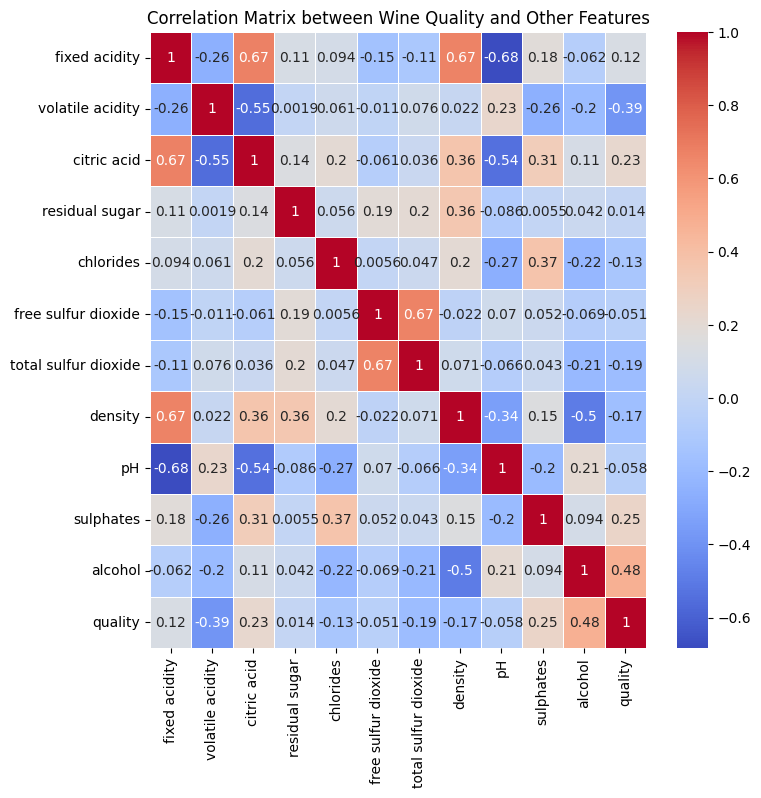

In [ ]:
# Load the dataset
url = "https://raw.githubusercontent.com/ryjason/CalculatorApp/refs/heads/master/notebooks/winequality-red.csv"
df = pd.read_csv(url, delimiter=';')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the matplotlib figure
plt.figure(figsize=(8, 8))

# Create a correlation matrix
correlation_matrix = df.corr()

# Plot a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix between Wine Quality and Other Features')
plt.show()


Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:51:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Hyperparameters: {'subsample': 0.6, 'n_estimators': 200, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Best F1 Score from Tuning: 0.8559609959608133


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:51:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Train Accuracy: 1.0000
Test Accuracy: 0.6375
Train F1 Score: 1.0000
Test F1 Score: 0.6418

Confusion Matrix:
[[ 0  1  1  0  0  0]
 [ 1  0  6  4  0  0]
 [ 0 10 95 30  1  0]
 [ 0  3 29 83 11  2]
 [ 0  0  2 10 25  3]
 [ 0  0  0  0  2  1]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00        11
           2       0.71      0.70      0.71       136
           3       0.65      0.65      0.65       128
           4       0.64      0.62      0.63        40
           5       0.17      0.33      0.22         3

    accuracy                           0.64       320
   macro avg       0.36      0.38      0.37       320
weighted avg       0.65      0.64      0.64       320



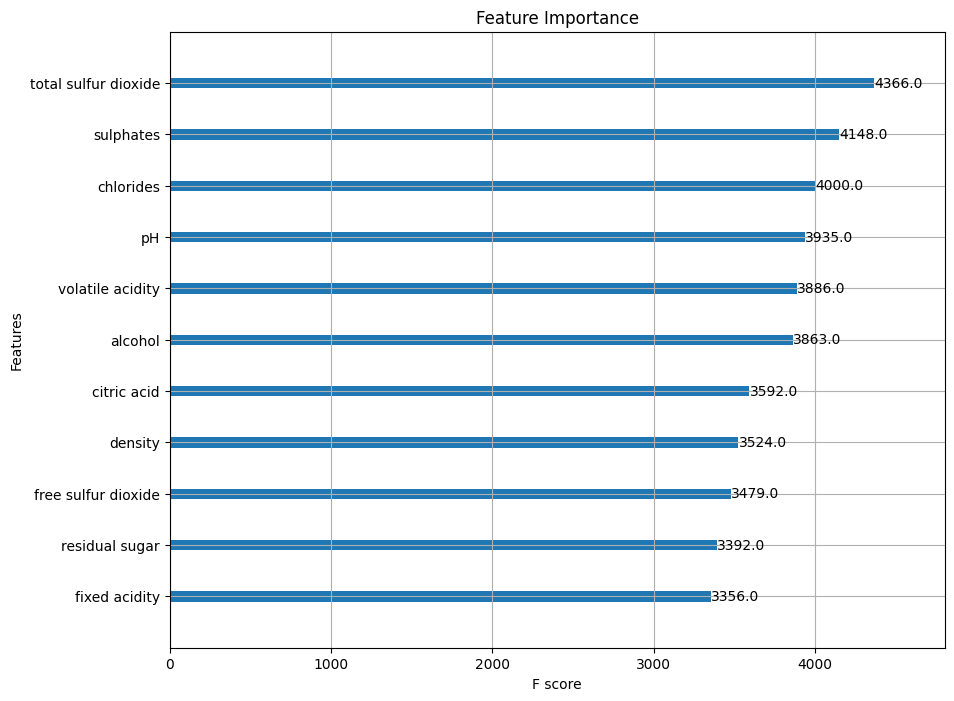

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

# Load the dataset
url = "https://raw.githubusercontent.com/ryjason/CalculatorApp/refs/heads/master/notebooks/winequality-red.csv"
df = pd.read_csv(url, delimiter=';')

# Separate features (X) and target variable (y)
X = df.drop(columns=['quality'])
y = df['quality']

# ----> Subtracting minimum value (3) to adjust labels starting from 0
y = y - y.min()
# <----

# Split the dataset into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Apply SMOTE for Balancing
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Initialize the XGBoost Classifier for Hyperparameter Tuning
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 6, 9, 12],
    'n_estimators': [100, 200, 300],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_grid,
    n_iter=50,  # Number of parameter settings that are sampled
    scoring='f1_weighted',  # Optimize for weighted F1 Score
    cv=3,  # 3-fold cross-validation
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit the model with hyperparameter tuning
random_search.fit(X_train_balanced, y_train_balanced)

# Print the best parameters and best score
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)
print("Best F1 Score from Tuning:", random_search.best_score_)

# Train the final model using the best hyperparameters
final_model = XGBClassifier(
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    n_estimators=best_params['n_estimators'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

final_model.fit(X_train_balanced, y_train_balanced)

# Make Predictions
y_train_pred = final_model.predict(X_train_balanced)
y_test_pred = final_model.predict(X_test)

# Evaluate the Model
train_accuracy = accuracy_score(y_train_balanced, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
train_f1 = f1_score(y_train_balanced, y_train_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

# Display Results
print(f"\nTrain Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Train F1 Score: {train_f1:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# Display Confusion Matrix and Classification Report
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

# Plot Feature Importance
fig, ax = plt.subplots(figsize=(10, 8))
plot_importance(final_model, ax=ax)
plt.title("Feature Importance")
plt.show()
